In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from flair.data import Sentence
from flair.embeddings import WordEmbeddings

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

from gensim.models import KeyedVectors, word2vec

from dataset import BibleDataset, custom_collate_fn
from model import AspectAutoencoder
from loss import TripletMarginCosineLoss, OrthogonalityLoss
from train_wv import get_wv

In [3]:
import nltk
home_path = os.path.expanduser('~')
if not os.path.exists(os.path.join(home_path, 'nltk_data/corpora/stopwords')):
    nltk.download('stopwords')

In [4]:
dataset = BibleDataset("./t_kjv.csv", word_to_index=True)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=custom_collate_fn)

In [5]:
bible_wv = get_wv()

load word bible embedding from bible_word2vec_org 


In [6]:
bible_wv.vocab['jesus'].index

139

In [7]:
bible_wv.vocab['love'].count

12429

In [8]:
""" Generate Word Vectors for a Given Dataset """

embed_size = bible_wv.vector_size
vocab_size = len(bible_wv.vocab)
wv = KeyedVectors(vector_size=embed_size)

embeddings = torch.empty(vocab_size, embed_size)

for word, voc in tqdm(bible_wv.vocab.items()):
    embeddings[voc.index] = torch.from_numpy(bible_wv[word]).to(embeddings)

  0%|          | 0/12755 [00:00<?, ?it/s]

In [9]:
""" Find K aspects in a Given Dataset using K-Means """

n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bible_wv.vectors)
centers = kmeans.cluster_centers_

for i in range(n_clusters):
    print([word for word, _ in bible_wv.similar_by_vector(centers[i])])
    print()

['horem', 'kelita', 'uzzia', 'hodijah', 'massa', 'bilgah', 'eri', 'jehud', 'miamin', 'bethpalet']

['cedar', 'filleted', 'bars', 'iron', 'spearmen', 'brass', 'oxen', 'rings', 'horses', 'boards']

['yet', 'nothing', 'done', 'how', 'known', 'good', 'that', 'well', 'because', 'evil']

['shadow', 'wall', 'field', 'deep', 'wind', 'hill', 'ground', 'hills', 'street', 'river']

['uzzia', 'horem', 'bethpalet', 'eri', 'kelita', 'massa', 'hodijah', 'rehob', 'becher', 'heshmon']

['fall', 'flee', 'bring', 'lie', 'stand', 'turn', 'rise', 'go', 'break', 'depart']

['strength', 'lips', 'mouth', 'mind', 'ways', 'heart', 'sins', 'anger', 'tongue', 'iniquity']

['host', 'coasts', 'samaria', 'amorites', 'mount', 'ephraim', 'country', 'valley', 'tabernacle', 'gate']

['were', 'had', 'was', 'are', 'saw', 'waxeth', 'dwelt', 'being', 'wanteth', 'galilaeans']

['double', 'reins', 'folly', 'wholly', 'divine', 'reprove', 'weary', 'obtain', 'granted', 'upright']

['forth', 'down', 'up', 'out', 'into', 'away', '

In [10]:
def coverage(data, dist="cosine"):
    if dist == "cosine":
        mins = (cosine_distances(data) + np.eye(len(data)) * 1e5).min(axis=1)
    elif dist == "euclidean":
        mins = (euclidean_distances(data) + np.eye(len(data)) * 1e5).min(axis=1)
    return np.square(np.var(mins)) / mins.mean()

In [11]:
w_emb = torch.from_numpy(bible_wv.vectors)
a_emb = torch.from_numpy(centers)
seed_w = None
num_seeds = None
lr = 0.01
epochs = 50
min_len = 1
l = 0.1
fix_a_emb = False

net = AspectAutoencoder(vocab_size, embed_size, num_aspects=n_clusters, neg_samples=10, w_emb=w_emb, a_emb=a_emb, recon_method="centr", seed_w=seed_w, num_seeds=num_seeds, attention=True, fix_w_emb=True, fix_a_emb=fix_a_emb)

if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    net = net.cuda()

rec_loss = TripletMarginCosineLoss()
orth_loss = OrthogonalityLoss()

params = filter(lambda p: p.requires_grad, net.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [12]:
net.train()
for epoch in tqdm(range(epochs), desc='Total Epoch'):

    for lines, ids in tqdm(dataloader, position=0, leave=False, desc='Epoch {}'.format(epoch)):
        inputs = Variable(torch.Tensor(lines).long())

        if inputs.shape[1] < min_len:
            continue

        if torch.cuda.is_available():
            inputs = inputs.cuda()

        out, a_probs = net(inputs)

        positives, negatives = net.get_targets()
        loss = rec_loss(out, positives, negatives)

        if not fix_a_emb:
            aspects = net.get_aspects()
            loss += l * orth_loss(aspects)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
abae_centers = net.get_aspects().detach().cpu().numpy()

for i in range(n_clusters):
    print([word for word, _ in wv.similar_by_vector(abae_centers[i])])
    print()

['sorrow', 'joy', 'passion', 'spirit', 'grief', 'pride', 'glory', 'uplifting', 'delight', 'feelings']

['pharaoh', 'abimelech', 'rameses', 'ahasuerus', 'birthright', 'nebuchadnezzar', 'jewels', 'herod', 'stamps', 'melchizedek']

['fourteen', 'sixty', 'eighty', 'seventeen', 'nineteen', 'sixteen', 'eighteen', 'fifteen', 'seventy', 'thirteen']

['zur', 'acco', 'tob', 'gunite', 'gether', 'sin', 'hesed', '!', 'waste', 'sirs']

['lord', 'garden', 'church', 'gardens', 'altar', 'rooms', 'churches', 'houses', 'worship', 'temple']

['meshullam', 'asher', 'alvan', 'machir', 'paltiel', 'neriah', 'jehoram', 'hanoch', 'jehiel', 'alphaeus']

['everybody', 'thing', 'know', 'look', 'happier', 'looks', 'going', 'things', 'wondering', 'cares']

['rulers', 'syria', 'hilltops', 'neighbours', 'jews', 'lebanon', 'jerusalem', 'persia', 'israel', 'neighbouring']

['stomach', 'chest', 'ear', 'cord', 'neck', 'throat', 'liver', 'mouth', 'bone', 'wound']

['straight', 'fourth', 'sixth', 'seventh', 'eighth', 'fifth

In [17]:
coverage(centers), coverage(abae_centers)

(0.0012551458268828454, 3.613356302848305e-10)

In [18]:
outs = list()
poss = list()
aspects = list()
recon_embedding = list()
orign_embedding = list()
for lines, ids in dataloader:
    inputs = Variable(torch.Tensor(lines).long())

    if inputs.shape[1] < min_len:
        continue

    if torch.cuda.is_available():
        inputs = inputs.cuda()

    out, a_probs = net(inputs)

    positives, negatives = net.get_targets()

    outs.append(out.detach().cpu().numpy())
    poss.append(positives.detach().cpu().numpy())
    aspects.append(a_probs.detach().cpu().numpy())

    recon_embedding.append(out.detach().cpu().numpy())
    orign_embedding.append(positives.detach().cpu().numpy())

outs = np.concatenate(outs, axis=0)
poss = np.concatenate(poss, axis=0)
aspects = np.concatenate(aspects, axis=0)

cos_dis = list()
for a, b in zip(outs, poss):
    cos_dis.append(cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0, 0])
print(sum(cos_dis), sum(cos_dis) / len(cos_dis))

cos_dis_stat = [np.sum(np.array(cos_dis) <= i * 0.1) for i in range(1, 11)]
print(cos_dis_stat)

aspects_embedding = aspects.copy()
aspects = np.argmax(aspects, axis=1)
aspects_stat = [np.sum(aspects == i) for i in range(n_clusters)]
print(aspects_stat)

recon_embedding = np.concatenate(recon_embedding, axis=0)
orign_embedding = np.concatenate(orign_embedding, axis=0)
print(f"Epoch {epoch+1}", "recon: ", coverage(recon_embedding, "cosine"), "orign: ", coverage(orign_embedding, "cosine"))

15140.088637113571 0.4870858230258846
[0, 0, 109, 5055, 19324, 27571, 30153, 30816, 30967, 31070]
[4095, 229, 2151, 385, 3631, 2333, 1218, 736, 458, 698, 275, 371, 1750, 240, 3232, 565, 343, 251, 474, 524, 416, 282, 428, 614, 619, 149, 1127, 2218, 519, 752]


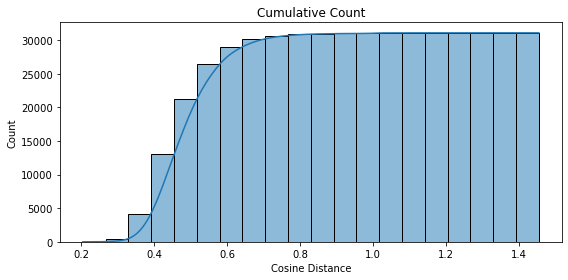

In [19]:
plt.figure(figsize=(8,4), tight_layout=True)
ax = sns.histplot(cos_dis, cumulative=True, bins=20, kde=True)
ax.set(title="Cumulative Count", xlabel="Cosine Distance", ylabel="Count")
plt.show()